In [2]:
import pandas as pd
import plotly.express as px
import matplotlib
from matplotlib import pyplot as plt
import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import random

# Generating COP and PLR curves
### Import tonnage and power data

In [55]:
tonnage = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Tons/Load_Data_Full_ChillerValuesOnly.csv')
power = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Power/Power_Data_Full_ChillerValuesOnly.csv')

In [ ]:
power

In [3]:
tonnage = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Tons/TONS/AHSC201718.csv')
power = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Power/KW/AHSC2018_ChillerValuesOnly.csv')

In [23]:
len(power)

262801

In [20]:
power = power[:262801]

In [41]:
power.columns[1:]

Index(['AHSC_CHL01_KW', 'AHSC_CHL02_KW', 'AHSC_CHL03_KW', 'AHSC_CHL04_KW',
       'AHSC_CHL07_KW', 'AHSC_CHL08_KW'],
      dtype='object')

In [62]:
power.head()

,Date,AHSC_CHL01_ChlrPwr,AHSC_CHL02_ChlrPwr,AHSC_CHL03_ChlrPwr,AHSC_CHL04_ChlrPwr,AHSC_CHL07_ChlrPwr,AHSC_CHL08_ChlrPwr
0,2/20/2018 12:00:00 AM,0.0,0.0,0.0,0.0,1145,0
1,2/20/2018 12:02:00 AM,0.0,0.0,0.0,0.0,1171,0
2,2/20/2018 12:04:00 AM,0.0,0.0,0.0,0.0,1158,0
3,2/20/2018 12:06:00 AM,0.0,0.0,0.0,0.0,1157,0
4,2/20/2018 12:08:00 AM,0.0,0.0,0.0,0.0,1078,0


In [46]:
kw_dict = {}
for s in power.columns[1:]:
    kw_dict[s] = s + '_ChlrPwr'
power.rename(kw_dict,inplace = True, axis = 1)

In [32]:
tons_rel_data = tons_rel_data[:-1]

In [57]:
tons_rel_data.head()

,Date,AHSC_CHL01_TONS,AHSC_CHL02_TONS,AHSC_CHL03_TONS,AHSC_CHL04_TONS,AHSC_CHL07_TONS,AHSC_CHL08_TONS
0,2/20/2018 12:00:00 AM,0.0,0.0,0.0,0.0,2328.609,0.0
1,2/20/2018 12:02:00 AM,0.0,0.0,0.0,0.0,2330.301,0.0
2,2/20/2018 12:04:00 AM,0.0,0.0,0.0,0.0,2269.054,0.0
3,2/20/2018 12:06:00 AM,0.0,0.0,0.0,0.0,2320.067,0.0
4,2/20/2018 12:08:00 AM,0.0,0.0,0.0,0.0,2139.363,0.0


In [48]:
tons_dict = {}
for s in tons_rel_data.columns[1:]:
    tons_dict[s] = s + '_TONS'
tons_rel_data.rename(tons_dict,axis = 1,inplace= True)

In [34]:
tons_rel_data.reset_index(drop = True,inplace = True)

In [6]:
mapper = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/IDmap.csv',header = None)
header_dict = {}
for (x,y) in zip(list(mapper.iloc[:,0]),list(mapper.iloc[:,1])):
    header_dict[x] = y
tonnage.rename(header_dict,axis = 1,inplace = True)

In [10]:
chiller_cols = [i * 2+1 for i in range(int(len(tonnage.columns)/2))]
chiller_cols = [tonnage.columns[x] for x in chiller_cols]
keep_cols = ['Date'] + chiller_cols
tons_rel_data = tonnage[keep_cols]

In [51]:
tonnage = tons_rel_data

### Generate dictionary of capacity values for chillers

In [53]:
capacity_dict = {'AHSC_CHL01':1300, 'AHSC_CHL02':1200,
       'AHSC_CHL03':1000, 'AHSC_CHL04':1200, 'AHSC_CHL07':2500,
       'AHSC_CHL08':2500} 
#                  ,'CRB_CHL05':1000, 'CRB_CHL06':2000,
#        'CRB_CHL07':1000, 'CRB_CHL08':2000, 'CRB_CHL09':2000,
#        'CRB_CHL10':2500, 'CHRP_CHL06':2000, 'CHRP_CHL07':2000,
#        'CHRP_CHL08':2000, 'CHRP_CHL09':2500, 'CHRP_CHL11':2500,
#        'CHRP_CHL12':2500}

The cell below shows how 16618 of the AHSC CHL04 tonnage values are above the capacity of the chiller. This should not be possible and results in a PLR value > 1.

In [31]:
# DEBUG
x = list(tonnage['AHSC_CHL04_TONS'])
count = 0
for i in range(len(x)):
    if x[i] > 1200:
        count += 1
print(count)

16618


### Generate kW/Ton Dataframe

In [74]:
kw_ton_dict = {}
for key in capacity_dict:
    power_lab = key + '_ChlrPwr'
    kw_data = list(power[power_lab])
    ton_lab = key + '_TONS'
    ton_data = list(tonnage[ton_lab])
    kw_ton_data = []
    for x,y in zip(kw_data,ton_data):
        try:
            kw_ton_data.append(x/y)
        except ZeroDivisionError:
            kw_ton_data.append(0)
    kw_ton_dict[key + '_kwPerTon'] = kw_ton_data

In [75]:
kw_ton = pd.DataFrame(kw_ton_dict)

In [76]:
kw_ton.head()

,AHSC_CHL01_kwPerTon,AHSC_CHL02_kwPerTon,AHSC_CHL03_kwPerTon,AHSC_CHL04_kwPerTon,AHSC_CHL07_kwPerTon,AHSC_CHL08_kwPerTon
0,0.0,0.0,0.0,0.0,0.491710,0.0
1,0.0,0.0,0.0,0.0,0.502510,0.0
2,0.0,0.0,0.0,0.0,0.510345,0.0
3,0.0,0.0,0.0,0.0,0.498692,0.0
4,0.0,0.0,0.0,0.0,0.503888,0.0


In [77]:
ahsc_kwton = kw_ton

### Save kW/Ton data to csv

In [58]:
kw_ton.to_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/AHSC_kw_per_ton_data_02202018_02202019.csv',index = False)

### Generate PLR Dataframe

In [67]:
plr_dict = {}
for key in capacity_dict:
    ton_lab = key + '_TONS'
    ton_data = list(tonnage[ton_lab])
    cap = capacity_dict[key]
    plr_data = [x/cap for x in ton_data]
    plr_dict[key + '_PLR'] = plr_data

In [68]:
plr = pd.DataFrame(plr_dict)

In [69]:
plr.head()

,AHSC_CHL01_PLR,AHSC_CHL02_PLR,AHSC_CHL03_PLR,AHSC_CHL04_PLR,AHSC_CHL07_PLR,AHSC_CHL08_PLR
0,0.0,0.0,0.0,0.0,0.931444,0.0
1,0.0,0.0,0.0,0.0,0.932120,0.0
2,0.0,0.0,0.0,0.0,0.907622,0.0
3,0.0,0.0,0.0,0.0,0.928027,0.0
4,0.0,0.0,0.0,0.0,0.855745,0.0


In [70]:
ahsc_plr = plr

### Save PLR data to csv

In [63]:
plr.to_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/AHSC_plr_data_02202018_02202019.csv',index = False)

### Generate curves

In [78]:
plr = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/plr_data_02122019_02122020.csv')
kw_ton = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/kw_per_ton_data_02122019_02122020.csv')

In [79]:
chillers = [x.split('_P')[0] for x in plr.columns]

In [80]:
chillers

['AHSC_CHL01',
 'AHSC_CHL02',
 'AHSC_CHL03',
 'AHSC_CHL04',
 'AHSC_CHL07',
 'AHSC_CHL08',
 'CRB_CHL05',
 'CRB_CHL06',
 'CRB_CHL07',
 'CRB_CHL08',
 'CRB_CHL09',
 'CRB_CHL10',
 'CHRP_CHL06',
 'CHRP_CHL07',
 'CHRP_CHL08',
 'CHRP_CHL09',
 'CHRP_CHL11',
 'CHRP_CHL12']

In [88]:
plr.head()

,AHSC_CHL01_PLR,AHSC_CHL02_PLR,AHSC_CHL03_PLR,AHSC_CHL04_PLR,AHSC_CHL07_PLR,AHSC_CHL08_PLR,CRB_CHL05_PLR,CRB_CHL06_PLR,CRB_CHL07_PLR,CRB_CHL08_PLR,CRB_CHL09_PLR,CRB_CHL10_PLR,CHRP_CHL06_PLR,CHRP_CHL07_PLR,CHRP_CHL08_PLR,CHRP_CHL09_PLR,CHRP_CHL11_PLR,CHRP_CHL12_PLR
0,0.929468,0.0,0.0,0.873085,0.0,0.0,0.0,0.0,0.893111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872478,0.0
1,0.932082,0.0,0.0,0.881211,0.0,0.0,0.0,0.0,0.883939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870654,0.0
2,0.932426,0.0,0.0,0.882323,0.0,0.0,0.0,0.0,0.886162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864858,0.0
3,0.929735,0.0,0.0,0.883452,0.0,0.0,0.0,0.0,0.881939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0
4,0.932074,0.0,0.0,0.885281,0.0,0.0,0.0,0.0,0.877716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0


In [92]:
plr.head()

,AHSC_CHL01_PLR,AHSC_CHL02_PLR,AHSC_CHL03_PLR,AHSC_CHL04_PLR,AHSC_CHL07_PLR,AHSC_CHL08_PLR,CRB_CHL05_PLR,CRB_CHL06_PLR,CRB_CHL07_PLR,CRB_CHL08_PLR,CRB_CHL09_PLR,CRB_CHL10_PLR,CHRP_CHL06_PLR,CHRP_CHL07_PLR,CHRP_CHL08_PLR,CHRP_CHL09_PLR,CHRP_CHL11_PLR,CHRP_CHL12_PLR
0,0.0,0.0,0.0,0.873085,0.0,0.0,0.0,0.0,0.893111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872478,0.0
1,0.0,0.0,0.0,0.881211,0.0,0.0,0.0,0.0,0.883939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870654,0.0
2,0.0,0.0,0.0,0.882323,0.0,0.0,0.0,0.0,0.886162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864858,0.0
3,0.0,0.0,0.0,0.883452,0.0,0.0,0.0,0.0,0.881939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0
4,0.0,0.0,0.0,0.885281,0.0,0.0,0.0,0.0,0.877716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0


In [87]:
kw_ton.head()

,AHSC_CHL01_kwPerTon,AHSC_CHL02_kwPerTon,AHSC_CHL03_kwPerTon,AHSC_CHL04_kwPerTon,AHSC_CHL07_kwPerTon,AHSC_CHL08_kwPerTon,CRB_CHL05_kwPerTon,CRB_CHL06_kwPerTon,CRB_CHL07_kwPerTon,CRB_CHL08_kwPerTon,CRB_CHL09_kwPerTon,CRB_CHL10_kwPerTon,CHRP_CHL06_kwPerTon,CHRP_CHL07_kwPerTon,CHRP_CHL08_kwPerTon,CHRP_CHL09_kwPerTon,CHRP_CHL11_kwPerTon,CHRP_CHL12_kwPerTon
0,0.0,0.0,0.0,0.530876,0.0,0.0,0.0,0.0,0.482135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468046,0.0
1,0.0,0.0,0.0,0.535343,0.0,0.0,0.0,0.0,0.486572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469027,0.0
2,0.0,0.0,0.0,0.540240,0.0,0.0,0.0,0.0,0.482530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470967,0.0
3,0.0,0.0,0.0,0.545116,0.0,0.0,0.0,0.0,0.484160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468226,0.0
4,0.0,0.0,0.0,0.535423,0.0,0.0,0.0,0.0,0.485920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465729,0.0


In [93]:
plr['AHSC_CHL01_PLR'] = ahsc_plr['AHSC_CHL01_PLR']
plr['AHSC_CHL02_PLR'] = ahsc_plr['AHSC_CHL02_PLR']
plr['AHSC_CHL03_PLR'] = ahsc_plr['AHSC_CHL03_PLR']
kw_ton['AHSC_CHL01_kwPerTon'] = ahsc_kwton['AHSC_CHL01_kwPerTon']
kw_ton['AHSC_CHL02_kwPerTon'] = ahsc_kwton['AHSC_CHL02_kwPerTon']
kw_ton['AHSC_CHL03_kwPerTon'] = ahsc_kwton['AHSC_CHL03_kwPerTon']

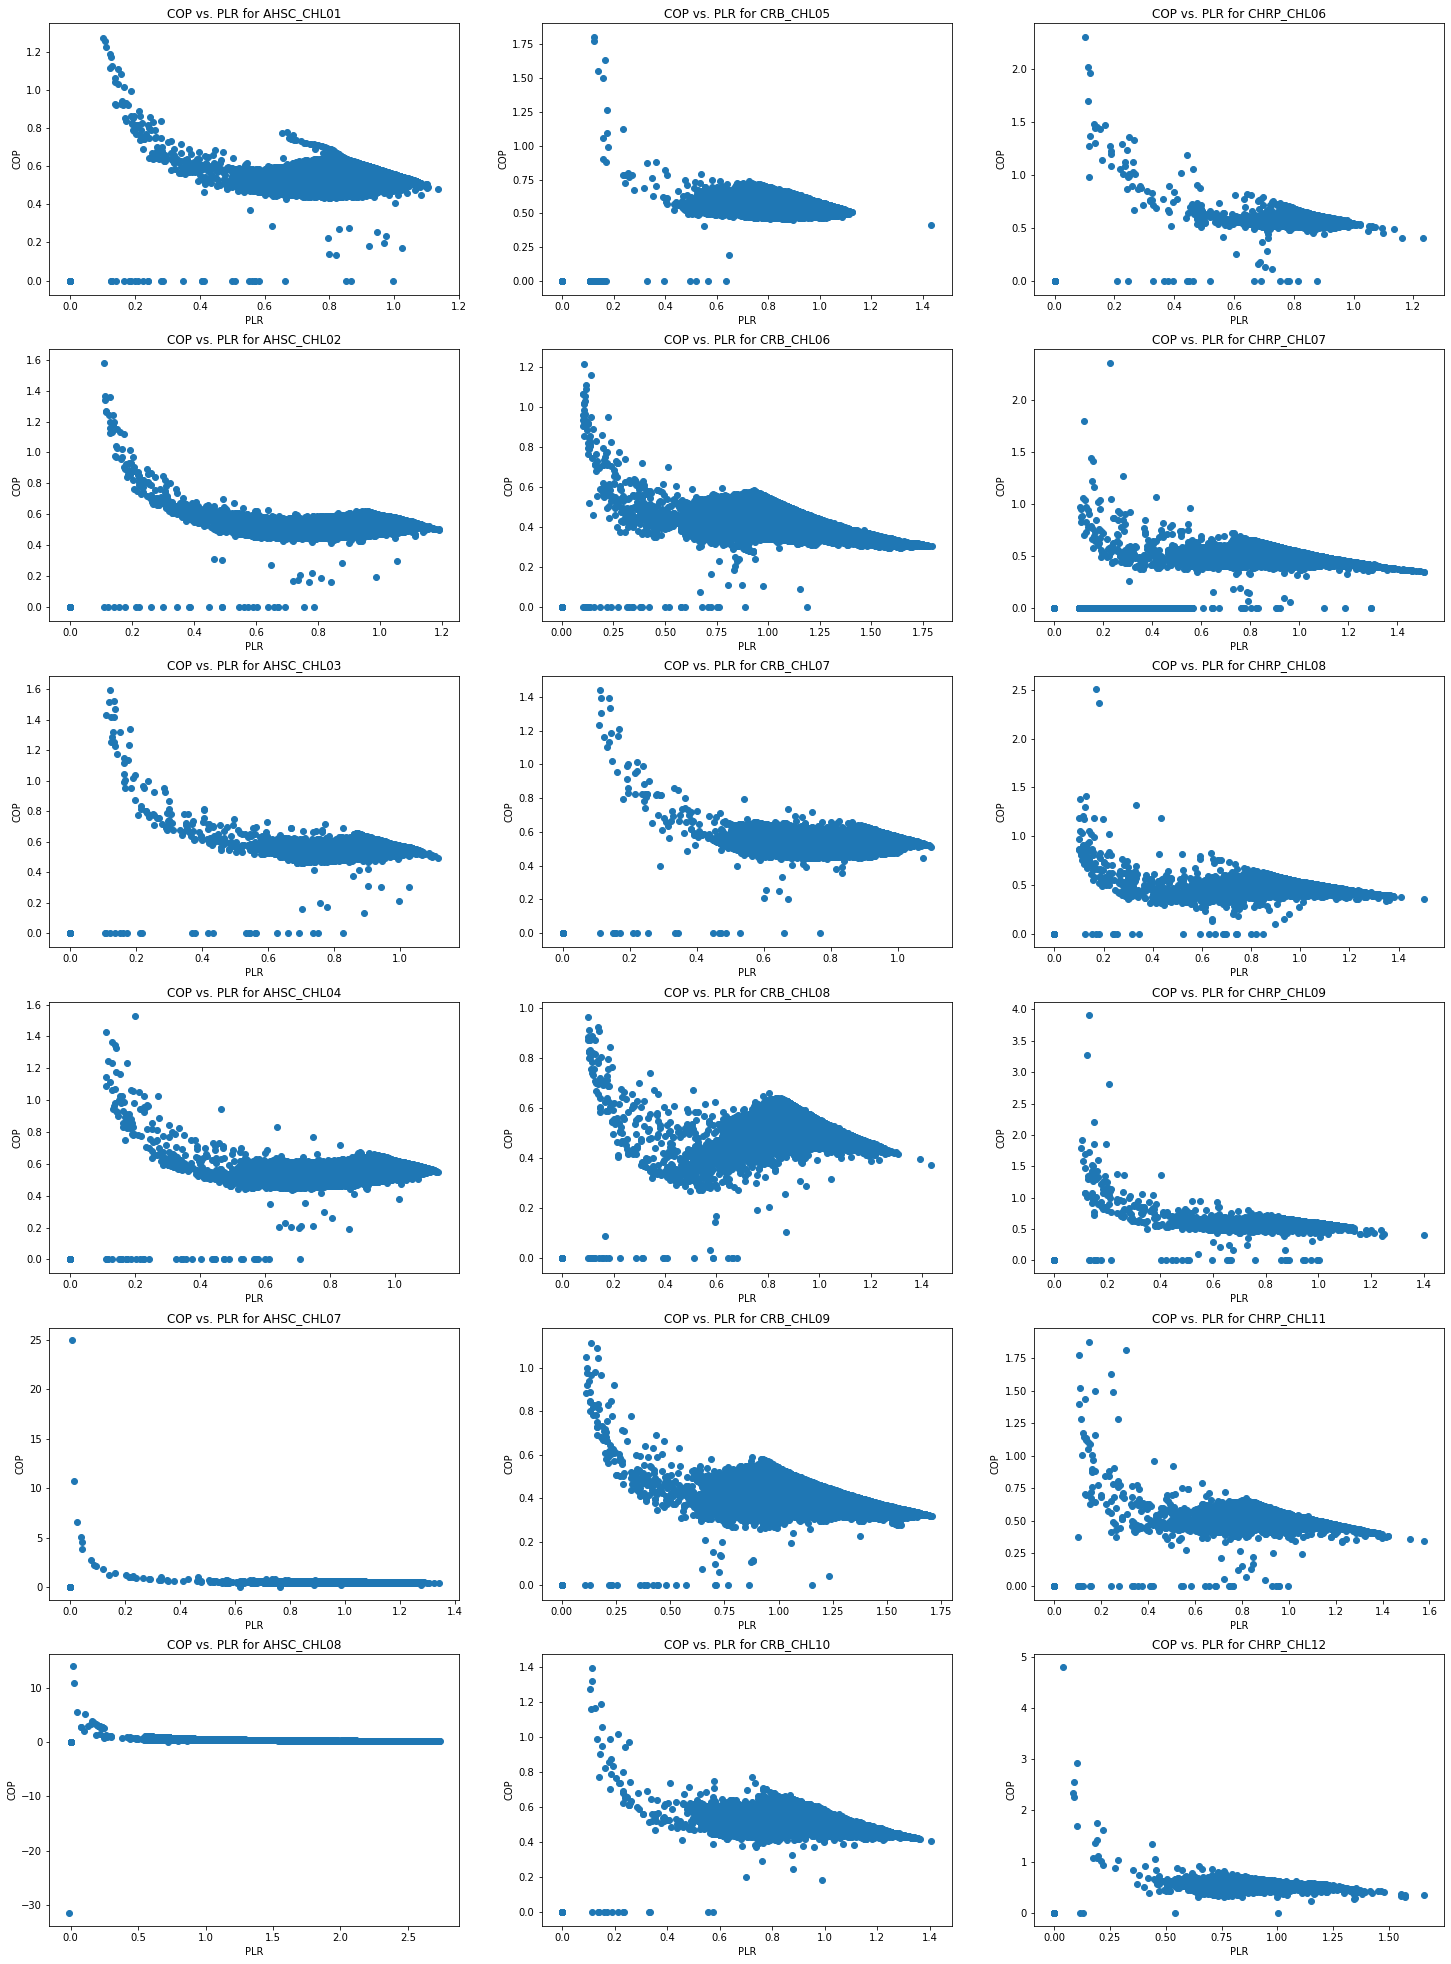

In [94]:
fig, host = plt.subplots(6,3,figsize=(25,35), facecolor='w')
for c in range(3):
    for r in range(6):
        chiller = chillers[c * 6 + r]
        plr_string = chiller + '_PLR'
        kw_ton_string = chiller + '_kwPerTon'
        x = list(plr[plr_string])
        y = list(kw_ton[kw_ton_string])
        # exclude negative values
        for i in range(len(x)):
            try:
                if (x[i] < 0 or y[i] < 0):
                    del x[i]
                    del y[i]
            except:
                pass
        host[r,c].set_xlabel("PLR")
        host[r,c].set_ylabel("COP")
        host[r,c].scatter(x, y)
        host[r,c].set_title('COP vs. PLR for {0}'.format(chiller))

plt.show()

## Heirarchical Regression

In [ ]:
import sys
sys.path.insert(1,'/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/CHRP-AI/DataAcquisition/Weather/scripts')
from darkSky import darkSky
# Retrieve weather data
dS = darkSky(32.229856, -110.952019)
start_date = datetime.date(2019,2,12)
curr_date = start_date
weather = pd.DataFrame()
while curr_date < start_date + datetime.timedelta(days = 365):
    weather = weather.append(dS.getData(curr_date),ignore_index = True)
    last = weather.iloc[-1,:]
    weather.drop(len(weather)-1,inplace = True)
    curr_date = curr_date + datetime.timedelta(days = 1)
weather.append(last,ignore_index = True)

In [68]:
odds = [2*x+1 for x in range(int(len(weather)/2 -1))]
weather.drop(odds,inplace = True)
weather.reset_index(drop = True,inplace = True)

In [90]:
plr = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/plr_data_02122019_02122020.csv')
kw_ton = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/kw_per_ton_data_02122019_02122020.csv')
master = pd.DataFrame({'PLR':plr['CRB_CHL09_PLR'],'COP':kw_ton['CRB_CHL09_kwPerTon'],'Temp':weather['Temperature in C']})

In [91]:
tempF = [x*1.8 + 32 for x in weather['Temperature in C']]
master.insert(2,'Temperature in F',tempF)

In [92]:
m1 = master[(master['Temperature in F'] > 20) & (master['Temperature in F'] <= 40)]
m2 = master[(master['Temperature in F'] > 40) & (master['Temperature in F'] <= 50)]
m3 = master[(master['Temperature in F'] > 50) & (master['Temperature in F'] <= 60)]
m4 = master[(master['Temperature in F'] > 60) & (master['Temperature in F'] <= 70)]
m5 = master[(master['Temperature in F'] > 70) & (master['Temperature in F'] <= 80)]
m6 = master[(master['Temperature in F'] > 80) & (master['Temperature in F'] <= 90)]
m7 = master[(master['Temperature in F'] > 90) & (master['Temperature in F'] <= 120)]
m = [m1,m2,m3,m4,m5,m6,m7]
temp_strings = ['20 to 40','40 to 50','50 to 60','60 to 70','70 to 80','80 to 90','90 to 120']

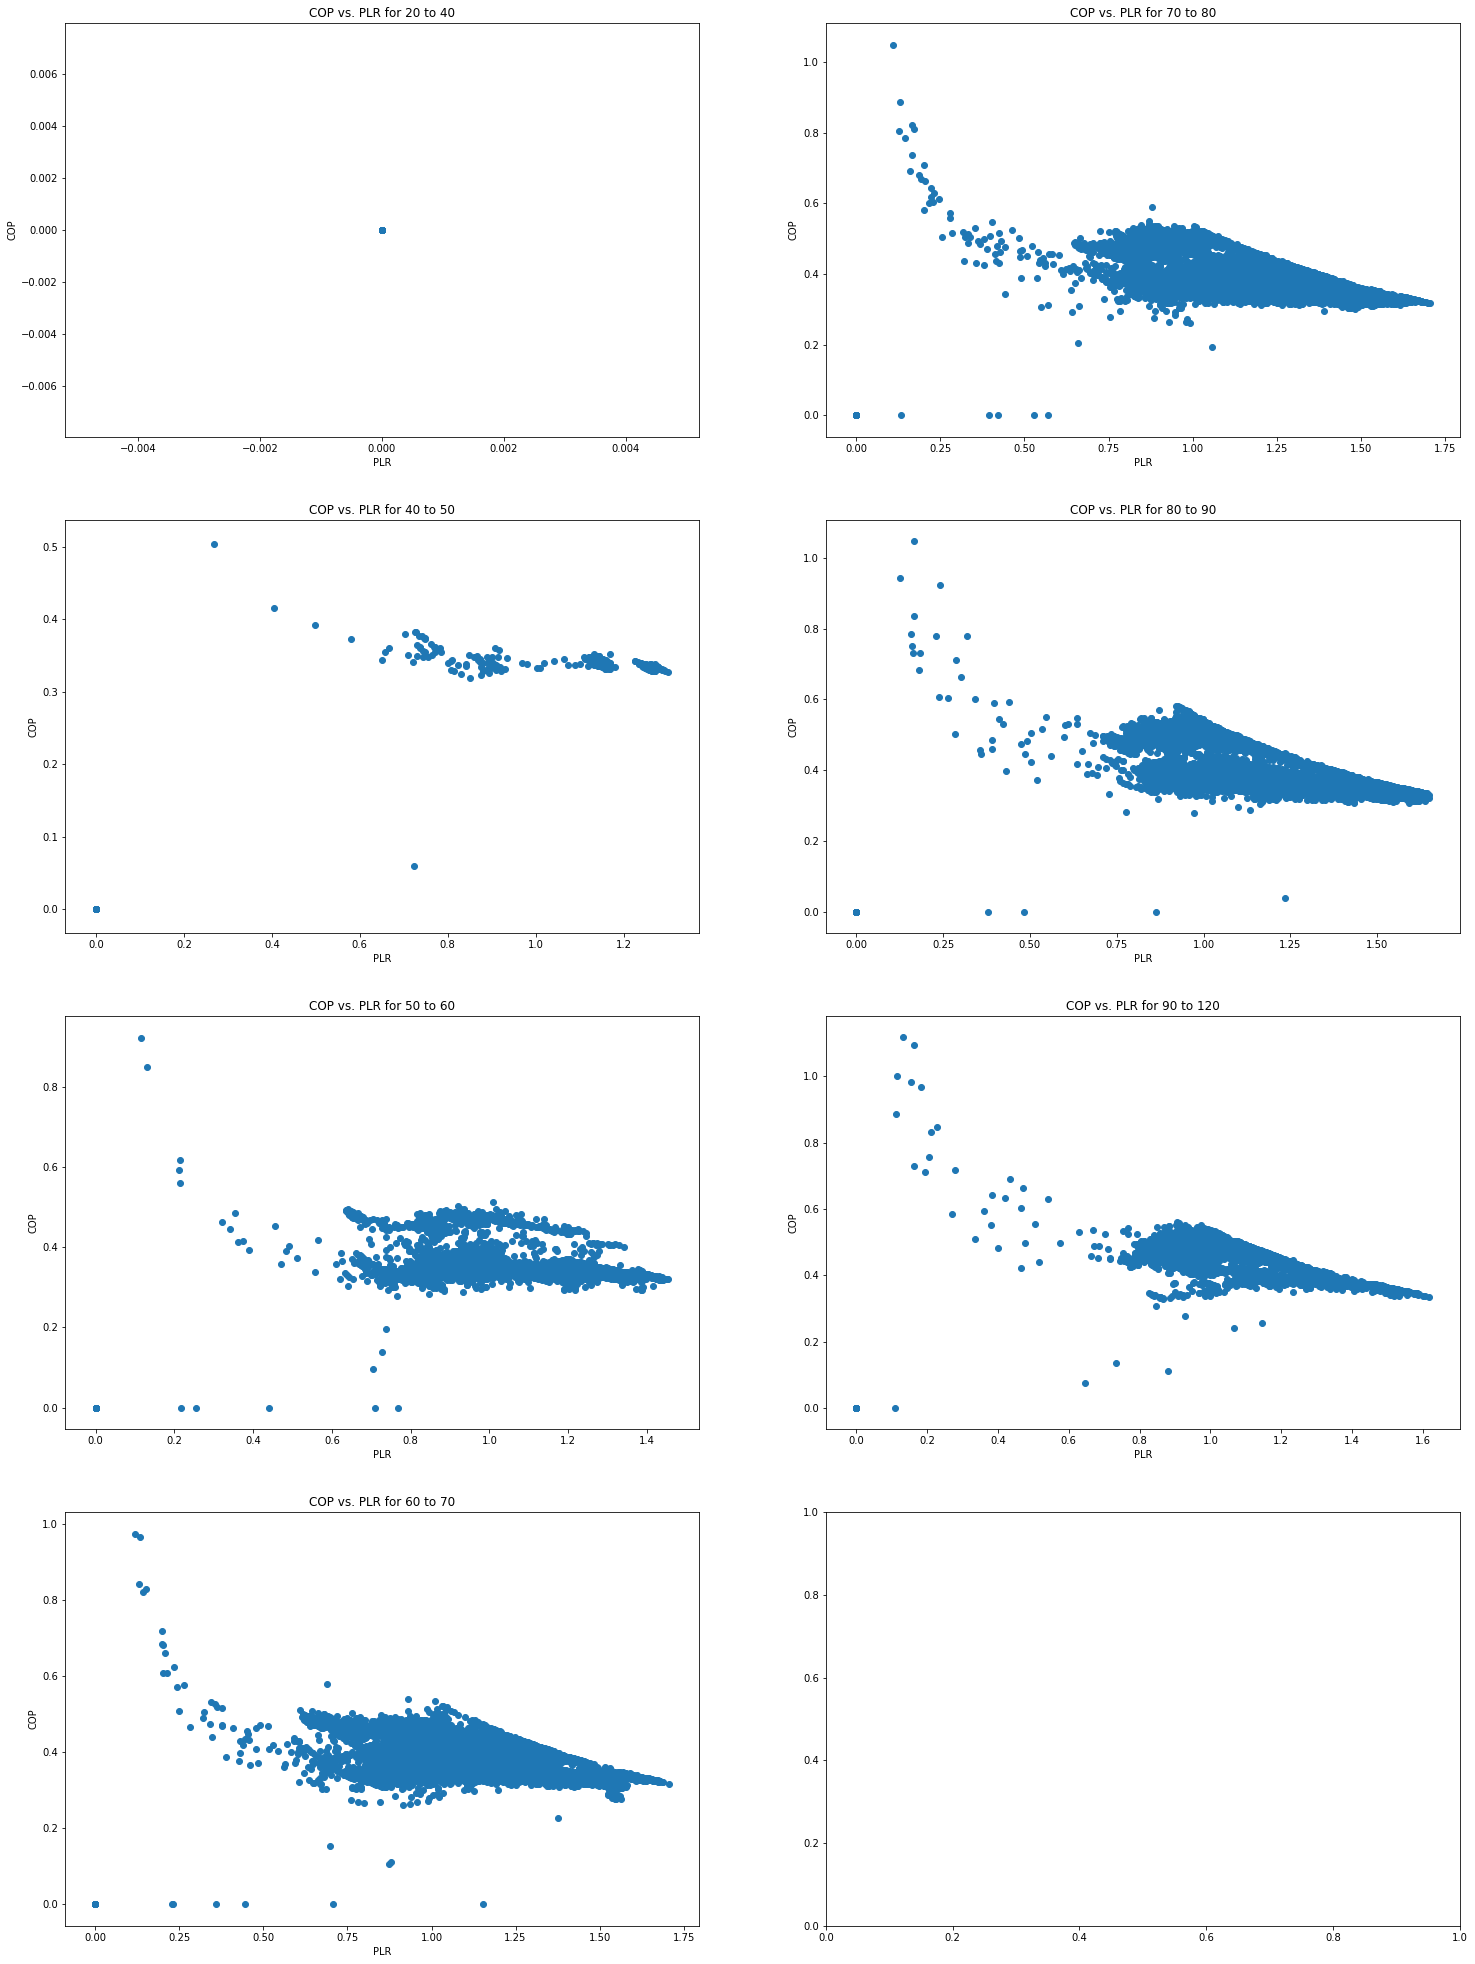

In [93]:
fig, host = plt.subplots(4,2,figsize=(25,35), facecolor='w')
for c in range(2):
    for r in range(4):
        if ((c == 1) & (r == 3)):
            break
#         chiller = chillers[c * 6 + r]
#         plr_string = chiller + '_PLR'
#         kw_ton_string = chiller + '_kwPerTon'
        x = list(m[c*4 + r]['PLR'])
        y = list(m[c*4 + r]['COP'])
        # exclude negative values
        for i in range(len(x)):
            try:
                if (x[i] < 0 or y[i] < 0):
                    del x[i]
                    del y[i]
            except:
                pass
        host[r,c].set_xlabel("PLR")
        host[r,c].set_ylabel("COP")
        host[r,c].scatter(x, y)
        host[r,c].set_title('COP vs. PLR for {0}'.format(temp_strings[c*4 + r]))

plt.show()

## Uniform Sampling across PLR range for Regression

In [7]:
chillers = chillers[3:]

Chiller: AHSC_CHL01
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: AHSC_CHL02
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: AHSC_CHL03
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: AHSC_CHL04
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: AHSC_CHL07
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: AHSC_CHL08
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: CRB_CHL05
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: CRB_CHL06
Finished cleaning.
Taking random sample.
Finished sampling.
Finished regression.
Finished plotting.

Chiller: CRB_CHL07
Finished cleani

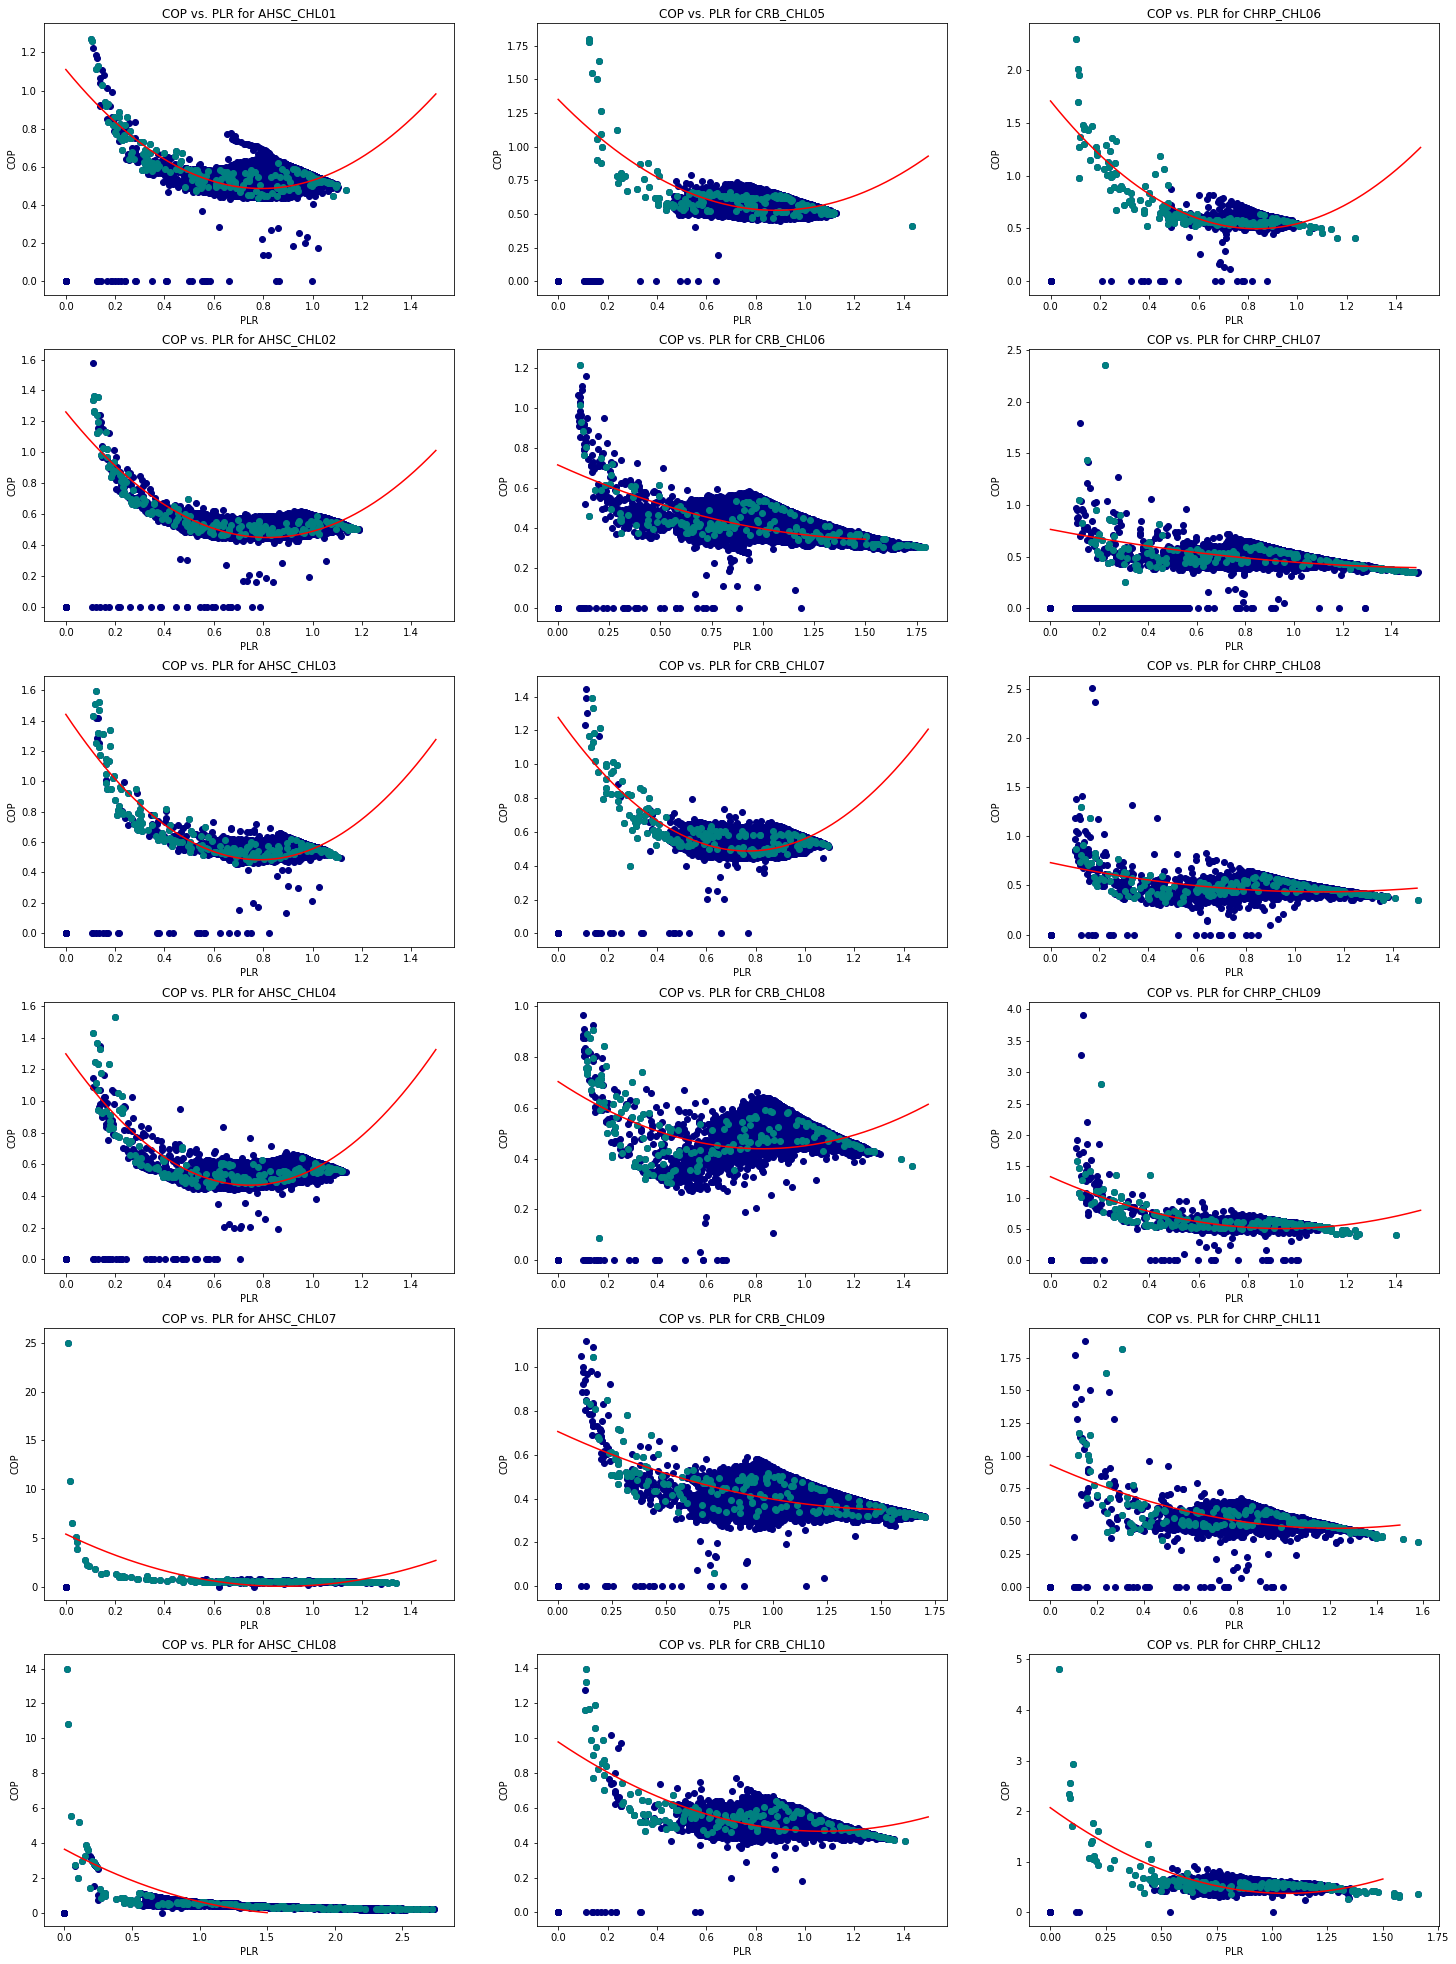

In [96]:
fig, host = plt.subplots(6,3,figsize=(25,35), facecolor='w')
# store regression coefficients
chills = []
a = []
b = []
cc = []
# chillers = chillers[3:]
for c in range(3):
    for r in range(6):
        chiller = chillers[c * 6 + r]
        print('Chiller: {0}'.format(chiller))
        plr_string = chiller + '_PLR'
        kw_ton_string = chiller + '_kwPerTon'
        x = plr[plr_string]
        y = kw_ton[kw_ton_string]
#         x = x.to_numpy()
#         y = y.to_numpy()
        # exclude negative values
        for i in range(len(x)):
            try:
                if (x[i] < 0 or y[i] < 0):
                    del x[i]
                    del y[i]
                    #print('Deleted point @ {0}'.format(i))
            except:
                pass
        # exclude points of y=0
        data = pd.DataFrame({'x':x,'y':y})
        data.sort_values('y',inplace = True)
        data.reset_index(drop = True,inplace = True)
        for i in range(len(data)):
            if data.loc[i,'y'] == 0:
                continue
            else:
                data = data.iloc[i:,:]
                break
        print('Finished cleaning.')
        #data = pd.DataFrame({'x':x,'y':y})
        data.sort_values('x',inplace = True)
        data.reset_index(drop = True,inplace = True)
        print('Taking random sample.')
        # take random sample -- n = sample size
        n = 200
        x_samp = []
        y_samp = []
        x_list = list(data['x'])
        y_list = list(data['y'])
        for i in range(n):
            # sample from uniform distribution on [plr_min,plr_max]
            rand = min(x_list) + (max(x_list) - min(x_list)) * random.random()
            j = 0
            while True:
                if x_list[j] <= rand:
                    j += 1
                else:
                    if abs(x_list[j] - rand) < abs(x_list[j-1] - rand):
                        ind = j
                    else:
                        ind = j-1
                    x_samp.append(x_list.pop(ind))
                    y_samp.append(y_list.pop(ind))
#                     data.drop(ind,inplace = True)
#                     data.reset_index(drop = True,inplace = True)
                    break
        print('Finished sampling.')
        # calculate regression
        x_samp = np.asarray(x_samp)#[:,np.newaxis]
        y_samp = np.asarray(y_samp)
        model = np.polyfit(x_samp,y_samp,2)
       
        chills.append(chiller)
        a.append(model[0])
        b.append(model[1])
        cc.append(model[2])
       #model.fit(x_samp,y_samp)
        print('Finished regression.')
        x_plot = np.linspace(0, 1.5, 1000)
        #x_plot = x_plot[:,np.newaxis]
        #y_plot = model.predict(x_plot)
        y_plot = np.polyval(model,x_plot) #model[0] * x_plot^2 + model[1] * x_plot + model[2]
        # plot
        host[r,c].plot(x_plot,y_plot,color = 'red')
        host[r,c].set_xlabel("PLR")
        host[r,c].set_ylabel("COP")
        host[r,c].scatter(x, y,color = 'navy')
        host[r,c].scatter(x_samp,y_samp,color = 'teal')
        host[r,c].set_title('COP vs. PLR for {0}'.format(chiller))
        print('Finished plotting.')
        print('')
coefficients = pd.DataFrame({'Chiller':chills,'a':a,'b':b,'c':cc}) # y = a*x^2 + b*x + c
plt.show()

In [98]:
filepath = '/Users/ethanweiss/Desktop/regression_coefficients_ss{0}.csv'.format(n)
coefficients.to_csv(filepath,index = False)

## Negative Values

In [4]:
tonnage = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Tons/Load_Data_Full_ChillerValuesOnly.csv')
power = pd.read_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/Chiller Power/Power_Data_Full_ChillerValuesOnly.csv')

In [13]:
negatives = pd.DataFrame(columns = ['DateTime','Value','Chiller'])
for i in range(len(tonnage)):
    row = list(tonnage.iloc[i,:])
    date = row.pop(0)
    index = 1
    for x in row:
        if x < 0:
            negatives = negatives.append({'DateTime':date,'Value':x,'Chiller':tonnage.columns[index]},ignore_index = True)
        index += 1
for i in range(len(power)):
    row = list(power.iloc[i,:])
    date = row.pop(0)
    index = 1
    for x in row:
        if x < 0:
            negatives = negatives.append({'DateTime':date,'Value':x,'Chiller':power.columns[index]},ignore_index = True)
        index += 1

In [ ]:
negatives.sort_values('Chiller',inplace = True)
negatives.reset_index(drop = True)

In [17]:
negatives.to_csv('/Users/ethanweiss/Desktop/Class documents/Spring 2020/Senior Design/negative_values.csv')

## View DataFrames

In [25]:
plr.head()

,AHSC_CHL01_PLR,AHSC_CHL02_PLR,AHSC_CHL03_PLR,AHSC_CHL04_PLR,AHSC_CHL07_PLR,AHSC_CHL08_PLR,CRB_CHL05_PLR,CRB_CHL06_PLR,CRB_CHL07_PLR,CRB_CHL08_PLR,CRB_CHL09_PLR,CRB_CHL10_PLR,CHRP_CHL06_PLR,CHRP_CHL07_PLR,CHRP_CHL08_PLR,CHRP_CHL09_PLR,CHRP_CHL11_PLR,CHRP_CHL12_PLR
0,0.929468,0.0,0.0,0.873085,0.0,0.0,0.0,0.0,0.893111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872478,0.0
1,0.932082,0.0,0.0,0.881211,0.0,0.0,0.0,0.0,0.883939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870654,0.0
2,0.932426,0.0,0.0,0.882323,0.0,0.0,0.0,0.0,0.886162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864858,0.0
3,0.929735,0.0,0.0,0.883452,0.0,0.0,0.0,0.0,0.881939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0
4,0.932074,0.0,0.0,0.885281,0.0,0.0,0.0,0.0,0.877716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865224,0.0


In [24]:
kw_ton.head()

,AHSC_CHL01_kwPerTon,AHSC_CHL02_kwPerTon,AHSC_CHL03_kwPerTon,AHSC_CHL04_kwPerTon,AHSC_CHL07_kwPerTon,AHSC_CHL08_kwPerTon,CRB_CHL05_kwPerTon,CRB_CHL06_kwPerTon,CRB_CHL07_kwPerTon,CRB_CHL08_kwPerTon,CRB_CHL09_kwPerTon,CRB_CHL10_kwPerTon,CHRP_CHL06_kwPerTon,CHRP_CHL07_kwPerTon,CHRP_CHL08_kwPerTon,CHRP_CHL09_kwPerTon,CHRP_CHL11_kwPerTon,CHRP_CHL12_kwPerTon
0,0.0,0.0,0.0,0.530876,0.0,0.0,0.0,0.0,0.482135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468046,0.0
1,0.0,0.0,0.0,0.535343,0.0,0.0,0.0,0.0,0.486572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469027,0.0
2,0.0,0.0,0.0,0.540240,0.0,0.0,0.0,0.0,0.482530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470967,0.0
3,0.0,0.0,0.0,0.545116,0.0,0.0,0.0,0.0,0.484160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468226,0.0
4,0.0,0.0,0.0,0.535423,0.0,0.0,0.0,0.0,0.485920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465729,0.0


In [3]:
tonnage.head()

,Date/Time,AHSC_CHL01_TONS,AHSC_CHL02_TONS,AHSC_CHL03_TONS,CHRP_CHL08_TONS,CHRP_CHL09_TONS,CHRP_CHL06_TONS,CHRP_CHL07_TONS,CHRP_CHL10_TONS,CHRP_CHL11_TONS,...,CRB_CHL07_TONS,CRB_CHL08_TONS,CRB_CHL09_TONS,CRB_CHL10_TONS,CRB_CHL01B_TONS,AHSC_CHL04_TONS,AHSC_CHL07_TONS,AHSC_CHL08_TONS,CRB_CHL02B_TONS,CRB_CHL03B_TONS
0,2019-02-12 00:00:00,1208.309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2181.195,...,893.11150,0.0,0.0,0.0,0.0,1047.702,0.0,0.0,0.0,0.0
1,2019-02-12 00:02:00,1211.706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2176.634,...,883.93870,0.0,0.0,0.0,0.0,1057.453,0.0,0.0,0.0,0.0
2,2019-02-12 00:04:00,1212.154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2162.145,...,886.16180,0.0,0.0,0.0,0.0,1058.788,0.0,0.0,0.0,0.0
3,2019-02-12 00:06:00,1208.656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2163.059,...,881.93895,0.0,0.0,0.0,0.0,1060.142,0.0,0.0,0.0,0.0
4,2019-02-12 00:08:00,1211.696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2163.059,...,877.71610,0.0,0.0,0.0,0.0,1062.337,0.0,0.0,0.0,0.0


In [4]:
power.head()

,Date/Time,AHSC_CHL01_ChlrPwr,AHSC_CHL02_ChlrPwr,AHSC_CHL03_ChlrPwr,AHSC_CHL04_ChlrPwr,AHSC_CHL07_ChlrPwr,AHSC_CHL08_ChlrPwr,CRB_CHL05_ChlrPwr,CRB_CHL06_ChlrPwr,CRB_CHL07_ChlrPwr,CRB_CHL08_ChlrPwr,CRB_CHL09_ChlrPwr,CRB_CHL10_ChlrPwr,CHRP_CHL06_ChlrPwr,CHRP_CHL07_ChlrPwr,CHRP_CHL08_ChlrPwr,CHRP_CHL09_ChlrPwr,CHRP_CHL11_ChlrPwr,CHRP_CHL12_ChlrPwr
0,2019-02-12 00:00:00,0.0,0.0,0.0,556.2,0.0,0.0,0.0,0.0,430.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1020.9,0.0
1,2019-02-12 00:02:00,0.0,0.0,0.0,566.1,0.0,0.0,0.0,0.0,430.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1020.9,0.0
2,2019-02-12 00:04:00,0.0,0.0,0.0,572.0,0.0,0.0,0.0,0.0,427.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1018.3,0.0
3,2019-02-12 00:06:00,0.0,0.0,0.0,577.9,0.0,0.0,0.0,0.0,427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1012.8,0.0
4,2019-02-12 00:08:00,0.0,0.0,0.0,568.8,0.0,0.0,0.0,0.0,426.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1007.4,0.0
